<a href="https://colab.research.google.com/github/Laplo/tp_machine_learning/blob/master/TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quelle est la population ayant le plus de risques de contracter le Covid-19 ?**

## **Import des librairies**

In [0]:
import pandas as pd
import numpy as np
import os

from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import des données**

In [3]:
train = pd.read_csv('drive/My Drive/Colab Notebooks/Data/diagnosis-of-covid-19-and-its-clinical-spectrum.csv')
train.drop(["myeloblasts","urine_urobilinogen"],axis=1,inplace=True)
train.drop(["patient_addmited_to_regular_ward_1_yes_0_no","patient_addmited_to_semi_intensive_unit_1_yes_0_no","patient_addmited_to_intensive_care_unit_1_yes_0_no"],axis=1, inplace=True)
train.sample(10)

,patient_id,patient_age_quantile,sars_cov_2_exam_result,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,basophils,mean_corpuscular_hemoglobin_mch,eosinophils,mean_corpuscular_volume_mcv,monocytes,red_blood_cell_distribution_width_rdw,serum_glucose,respiratory_syncytial_virus,influenza_a,influenza_b,parainfluenza_1,coronavirusnl63,rhinovirus_enterovirus,mycoplasma_pneumoniae,coronavirus_hku1,parainfluenza_3,chlamydophila_pneumoniae,adenovirus,parainfluenza_4,coronavirus229e,coronavirusoc43,inf_a_h1n1_2009,bordetella_pertussis,metapneumovirus,parainfluenza_2,neutrophils,urea,proteina_c_reativa_mg_dl,creatinine,...,myelocytes,urine_esterase,urine_aspect,urine_ph,urine_hemoglobin,urine_bile_pigments,urine_ketone_bodies,urine_nitrite,urine_density,urine_protein,urine_sugar,urine_leukocytes,urine_crystals,urine_red_blood_cells,urine_hyaline_cylinders,urine_granular_cylinders,urine_yeasts,urine_color,partial_thromboplastin_time_ptt,relationship_patient_normal,international_normalized_ratio_inr,lactic_dehydrogenase,prothrombin_time_pt_activity,vitamin_b12,creatine_phosphokinase_cpk,ferritin,arterial_lactic_acid,lipase_dosage,d_dimer,albumin,hb_saturation_arterial_blood_gases,pco2_arterial_blood_gas_analysis,base_excess_arterial_blood_gas_analysis,ph_arterial_blood_gas_analysis,total_co2_arterial_blood_gas_analysis,hco3_arterial_blood_gas_analysis,po2_arterial_blood_gas_analysis,arteiral_fio2,phosphor,cto2_arterial_blood_gas_analysis
2931,860e5d1c2aaf286,19,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3900,677c3224d816bf8,6,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2742,0cae5384b208106,12,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1747,78a41732558deae,12,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3992,4c106c4a9f4831a,17,negative,0.488289,0.290940,0.374475,-0.438097,-0.232973,-0.918346,-0.652057,0.322808,-0.834685,0.909977,0.007280,1.367966,-0.482876,0.967144,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,1.134611,NaN,-0.521453,-0.460184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2067,648ea75339b6980,0,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9

# Création des données de test

In [4]:
test = pd.read_csv('drive/My Drive/Colab Notebooks/Data/diagnosis-of-covid-19-and-its-clinical-spectrum.csv')
test.drop(["myeloblasts","urine_urobilinogen"],axis=1,inplace=True)
test.drop(["sars_cov_2_exam_result","patient_addmited_to_regular_ward_1_yes_0_no","patient_addmited_to_semi_intensive_unit_1_yes_0_no","patient_addmited_to_intensive_care_unit_1_yes_0_no"], axis=1, inplace=True)
test.sample(10)

,patient_id,patient_age_quantile,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,basophils,mean_corpuscular_hemoglobin_mch,eosinophils,mean_corpuscular_volume_mcv,monocytes,red_blood_cell_distribution_width_rdw,serum_glucose,respiratory_syncytial_virus,influenza_a,influenza_b,parainfluenza_1,coronavirusnl63,rhinovirus_enterovirus,mycoplasma_pneumoniae,coronavirus_hku1,parainfluenza_3,chlamydophila_pneumoniae,adenovirus,parainfluenza_4,coronavirus229e,coronavirusoc43,inf_a_h1n1_2009,bordetella_pertussis,metapneumovirus,parainfluenza_2,neutrophils,urea,proteina_c_reativa_mg_dl,creatinine,potassium,...,myelocytes,urine_esterase,urine_aspect,urine_ph,urine_hemoglobin,urine_bile_pigments,urine_ketone_bodies,urine_nitrite,urine_density,urine_protein,urine_sugar,urine_leukocytes,urine_crystals,urine_red_blood_cells,urine_hyaline_cylinders,urine_granular_cylinders,urine_yeasts,urine_color,partial_thromboplastin_time_ptt,relationship_patient_normal,international_normalized_ratio_inr,lactic_dehydrogenase,prothrombin_time_pt_activity,vitamin_b12,creatine_phosphokinase_cpk,ferritin,arterial_lactic_acid,lipase_dosage,d_dimer,albumin,hb_saturation_arterial_blood_gases,pco2_arterial_blood_gas_analysis,base_excess_arterial_blood_gas_analysis,ph_arterial_blood_gas_analysis,total_co2_arterial_blood_gas_analysis,hco3_arterial_blood_gas_analysis,po2_arterial_blood_gas_analysis,arteiral_fio2,phosphor,cto2_arterial_blood_gas_analysis
1187,2e34dbf6ebc86b7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2814,924f9514f2ea15e,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1457,08e7acdc4860ecf,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3673,7ca38439861a073,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5016,c3c08e6b5fb20d7,12,-1.319907,-1.150148,0.273981,-0.325903,-1.308424,-1.268037,0.443306,0.275501,0.081693,0.439533,-0.70909,0.26634,0.646442,-0.625073,-0.716053,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,1.232949,-0.811643,-0.477739,-1.114943,-0.80011,...,NaN,absent,clear,5,absent,absent,NaN,NaN,-1.331803,absent,NaN,4000,Ausentes,-0.202297,absent,absent,absent,light_yellow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3612,0f434d5931d9819,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1506,e5b3a6cf2fa9a66,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Préparation des données de training

# Création des catégories 

In [0]:
train["urine_crystals"] = train["urine_crystals"].map(
    {    "Ausentes": 0,
         "Urato Amorfo --+": 1,
         "Oxalato de Cálcio +++": 2,
         "Oxalato de Cálcio -++": 3,
         "Urato Amorfo +++": 4,
    }
) 

train["urine_color"] = train["urine_color"].map(
    {    "light_yellow": 0,
         "yellow": 1,
         "orange": 2,
         "citrus_yellow": 3,
    }
) 

train["urine_aspect"] = train["urine_aspect"].map(
    {    "clear": 0,
         "cloudy": 1,
         "altered_coloring": 2,
         "lightly_cloudy": 3,
    }
) 



In [0]:
train = train.replace(to_replace="detected",value=1)
train = train.replace(to_replace="not_detected",value=0)
train = train.replace(to_replace="not_done",value=-299)
train = train.replace(to_replace="absent",value=0)
train = train.replace(to_replace="present",value=1)
train = train.replace(to_replace="Não Realizado",value=-299)
train = train.replace(to_replace="negative",value=0)
train = train.replace(to_replace="<1000",value=0)
train = train.replace(to_replace="positive",value=1)

train = train.replace(to_replace=np.NaN,value=-299)

train["urine_ph"] = train["urine_ph"].astype(np.float)
train["urine_leukocytes"] = train["urine_leukocytes"].astype(np.float)

In [7]:
mid = train['sars_cov_2_exam_result']
train.drop(labels=['sars_cov_2_exam_result'], axis=1, inplace = True)
train.insert(1, 'sars_cov_2_exam_result', mid)

X_alltrain = pd.DataFrame(train.iloc[:, 2:]).to_numpy()
print("Type of X_alltrain :", type(X_alltrain))
X_alltrain[:10]

Type of X_alltrain : <class 'numpy.ndarray'>


array([[ 1.30000000e+01, -2.99000000e+02, -2.99000000e+02, ...,
        -2.99000000e+02, -2.99000000e+02, -2.99000000e+02],
       [ 1.70000000e+01,  2.36515447e-01, -2.23402679e-02, ...,
        -2.99000000e+02, -2.99000000e+02, -2.99000000e+02],
       [ 8.00000000e+00, -2.99000000e+02, -2.99000000e+02, ...,
        -2.99000000e+02, -2.99000000e+02, -2.99000000e+02],
       ...,
       [ 1.60000000e+01, -2.99000000e+02, -2.99000000e+02, ...,
        -2.99000000e+02, -2.99000000e+02, -2.99000000e+02],
       [ 1.00000000e+00, -1.57168221e+00, -7.74212003e-01, ...,
        -2.99000000e+02,  7.30392933e-01, -2.99000000e+02],
       [ 1.70000000e+01, -2.99000000e+02, -2.99000000e+02, ...,
        -2.99000000e+02, -2.99000000e+02, -2.99000000e+02]])

# Chargement des labels

In [8]:
y_alltrain = pd.DataFrame(train[["sars_cov_2_exam_result"]]).to_numpy()
y_alltrain[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

# fonction utiles

In [0]:
def generer_resultats(clf,df_test=test):
    """
    Fonctions permettant de générer le fichier d'envoi à Kaggle.
    On passe un classifier sur lequel on refait le training avec toutes les données de training
    
    Parameters
    ----------
    Classifiers : Classifier utilisé pour la prédiction
    data : Données à calculer. par défaut, les valeurs du dataset "test"
    idx : Index des passagers testés. Stockés dans finalfile_index lors de la lecture des données
    """    
    data = df_test.iloc[:,1:].values
    idx = df_test.patient_id
    print(clf.get_params())
    clf.fit(X_alltrain, y_alltrain)
    prediction=clf.predict(data)
    results=pd.DataFrame(prediction.astype(int), index = df_test.patient_id, columns=['sars_cov_2_exam_result'])
    results.to_csv('resultats%s.csv'%clf.__class__.__name__)
  


def plot_decision_boundary(clf,X,y, axes=[-0, 30, -5, 5], axis_name=['x1','x2'],alpha=0.5, contour=True):
    """
    Fonction pour l'affichage 2 D des résultats   
    
    Parameters
    ----------
    clf : Classifier à afficher
    X : features de Données a afficher
    y : labels de Données a afficher  
    axes : : Tailles des axes (valeur min/max)
    axis_name : Nom des axes sur le graphique
    alpha : Transparence des points
    contour : Afichage du contour
    """     
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bo",label="Negatif", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ys", label="Positif",alpha=alpha)
    plt.axis(axes)
    plt.xlabel(axis_name[0], fontsize=18)
    plt.ylabel(axis_name[1]+ "  ",fontsize=18, rotation=0)    
    plt.legend(loc="lower right", fontsize=14)

# Création forêt

In [0]:
pd.options.display.max_rows=150

In [11]:
train["hematocrit"].unique()

array([-2.99000000e+02,  2.36515447e-01, -1.57168221e+00, -7.47693062e-01,
        9.91838217e-01,  1.90738127e-01,  1.01472640e+00,  7.40064204e-01,
       -6.79027498e-01,  8.08729768e-01, -1.06813163e-01,  1.42672145e+00,
        7.17175126e-01,  9.46060896e-01,  6.25621319e-01, -1.52590483e-01,
        6.71397805e-01, -2.21256033e-01, -8.16359460e-01, -6.56139314e-01,
       -5.18807352e-01,  4.42512095e-01, -5.41696429e-01, -4.50141758e-01,
        1.22072399e+00,  2.82292753e-01,  6.94286883e-01, -8.62135947e-01,
        5.79843998e-01,  3.05179283e-02, -3.81476171e-02, -1.29701912e+00,
       -1.98367643e+00,  1.03761554e+00,  2.09048939e+00, -4.04364437e-01,
        7.62952447e-01,  1.49538696e+00, -7.01916635e-01, -1.36568463e+00,
       -1.06813335e+00,  1.10628104e+00, -3.81476223e-01,  1.17494667e+00,
        3.05180997e-01, -7.93470383e-01,  1.38094413e+00,  1.72427273e+00,
        3.96735638e-01,  1.63271809e+00,  1.08339286e+00,  4.65401143e-01,
        1.24361217e+00,  

# Séparation des features et labels

In [12]:
X_train, X_dev, y_train, y_dev = train_test_split(X_alltrain, y_alltrain, random_state=42)
print('Rows & cols of X_train', X_train.shape)
print('Rows & cols of y_train', y_train.shape)
print('Rows & cols of X_dev', X_dev.shape)
print('Rows & cols of y_dev', y_dev.shape)

Rows & cols of X_train (4233, 104)
Rows & cols of y_train (4233, 1)
Rows & cols of X_dev (1411, 104)
Rows & cols of y_dev (1411, 1)


In [0]:
feature_names = train.columns[2:].values.tolist()

In [14]:
train.dtypes

patient_id                                         object
sars_cov_2_exam_result                              int64
patient_age_quantile                                int64
hematocrit                                        float64
hemoglobin                                        float64
platelets                                         float64
mean_platelet_volume                              float64
red_blood_cells                                   float64
lymphocytes                                       float64
mean_corpuscular_hemoglobin_concentration_mchc    float64
leukocytes                                        float64
basophils                                         float64
mean_corpuscular_hemoglobin_mch                   float64
eosinophils                                       float64
mean_corpuscular_volume_mcv                       float64
monocytes                                         float64
red_blood_cell_distribution_width_rdw             float64
serum_glucose 

In [15]:
train.isin([np.NaN]).any()

patient_id                                        False
sars_cov_2_exam_result                            False
patient_age_quantile                              False
hematocrit                                        False
hemoglobin                                        False
platelets                                         False
mean_platelet_volume                              False
red_blood_cells                                   False
lymphocytes                                       False
mean_corpuscular_hemoglobin_concentration_mchc    False
leukocytes                                        False
basophils                                         False
mean_corpuscular_hemoglobin_mch                   False
eosinophils                                       False
mean_corpuscular_volume_mcv                       False
monocytes                                         False
red_blood_cell_distribution_width_rdw             False
serum_glucose                                   

In [16]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
for name, score in zip(feature_names, rnd_clf.feature_importances_):
    print('%s: %i%%' %(name, int(score*100)))
best = {}
best['score'] = 0
for x in range(1, 20):
  rnd_clf = RandomForestClassifier(n_estimators=(100 + ((100*x)%1000)), n_jobs=-1, random_state=42, max_depth=x, max_features=(1 + x%6))
  rnd_clf.fit(X_train, y_train.ravel())
  y_pred = rnd_clf.predict(X_dev)
  ac_score = accuracy_score(y_dev, y_pred)
  if ac_score >= best['score']:
    best['depth'] = x
    best['score'] = ac_score
    best['clf'] = rnd_clf
    best['features'] = (1 + x%6)
    best['estimators'] = (100 + ((100*x)%500))
  print('Score is', ac_score, 'as depth', x, 'with', (1 + x%6), 'features and estimators', (100 + ((100*x)%1000)))
print('Best score was', best['score'], 'as depth', best['depth'], 'with', best['features'], 'features and estimators', best['estimators'])

patient_age_quantile: 27%
hematocrit: 2%
hemoglobin: 1%
platelets: 2%
mean_platelet_volume: 1%
red_blood_cells: 2%
lymphocytes: 1%
mean_corpuscular_hemoglobin_concentration_mchc: 1%
leukocytes: 4%
basophils: 1%
mean_corpuscular_hemoglobin_mch: 1%
eosinophils: 1%
mean_corpuscular_volume_mcv: 1%
monocytes: 4%
red_blood_cell_distribution_width_rdw: 1%
serum_glucose: 0%
respiratory_syncytial_virus: 0%
influenza_a: 0%
influenza_b: 0%
parainfluenza_1: 0%
coronavirusnl63: 0%
rhinovirus_enterovirus: 1%
mycoplasma_pneumoniae: 0%
coronavirus_hku1: 0%
parainfluenza_3: 0%
chlamydophila_pneumoniae: 0%
adenovirus: 0%
parainfluenza_4: 0%
coronavirus229e: 0%
coronavirusoc43: 0%
inf_a_h1n1_2009: 0%
bordetella_pertussis: 0%
metapneumovirus: 0%
parainfluenza_2: 0%
neutrophils: 1%
urea: 1%
proteina_c_reativa_mg_dl: 2%
creatinine: 1%
potassium: 0%
sodium: 0%
influenza_b_rapid_test: 1%
influenza_a_rapid_test: 1%
alanine_transaminase: 0%
aspartate_transaminase: 1%
gamma_glutamyltransferase: 1%
total_bilirubi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: No contour levels were found within the data range.


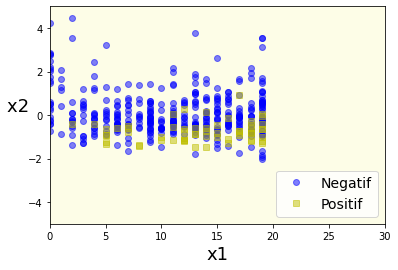

In [18]:
X_alltraintwo = pd.DataFrame(train[["patient_age_quantile", "leukocytes"]]).to_numpy()
y_alltraintwo = pd.DataFrame(train[["sars_cov_2_exam_result"]]).to_numpy()
X_traintwo, X_devtwo, y_traintwo, y_devtwo = train_test_split(X_alltraintwo, y_alltraintwo.ravel(), random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42, max_depth=4)
rnd_clf.fit(X_traintwo, y_traintwo)
plot_decision_boundary(rnd_clf, X_traintwo, y_traintwo.ravel())

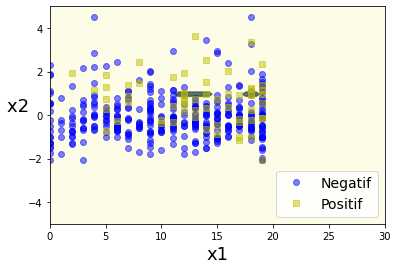

In [19]:
X_alltraintwo1 = pd.DataFrame(train[["patient_age_quantile", "monocytes"]]).to_numpy()
y_alltraintwo1 = pd.DataFrame(train[["sars_cov_2_exam_result"]]).to_numpy()
X_traintwo1, X_devtwo1, y_traintwo1, y_devtwo1 = train_test_split(X_alltraintwo1, y_alltraintwo1.ravel(), random_state=42)

rnd_clf1 = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42, max_depth=4)
rnd_clf1.fit(X_traintwo1, y_traintwo1)
plot_decision_boundary(rnd_clf1, X_traintwo1, y_traintwo1.ravel())

# Création de réseau de neurones 

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from sklearn.utils import shuffle

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

class Model(nn.Module):
    
    def __init__(self, input_dim, dropoutLayer):
        super(Model, self).__init__()   
        self.dropoutLayer = dropoutLayer     
        self.layer = nn.Linear(input_dim,50)   # Première couche de 50 neurones
        self.layer1 = nn.Linear(50, 50)         # première couche cachée de 50 neurones  
        self.layer2 = nn.Linear(50, 50)         # deuxième couche cachée de 50 neurones            
        self.layer4 = nn.Linear(50, 2)          # Couche de sortie de 2 neurones (2 classes)
        
    def forward(self, x):
        x = F.relu(self.layer(x))
        x = F.relu(self.layer1(x))
        if self.dropoutLayer:
            x = F.dropout(self.layer1(x), p=self.dropoutLayer)
        x = F.relu(self.layer2(x))
        if self.dropoutLayer:
            x = F.dropout(self.layer2(x), p=self.dropoutLayer)
        x = F.softmax(self.layer4(x),dim=1) # Application de la fonction softmax à la couche de sortie
        return x

model = Model(X_train.shape[1], 0.05)
print(model)

Model(
  (layer): Linear(in_features=104, out_features=50, bias=True)
  (layer1): Linear(in_features=50, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer4): Linear(in_features=50, out_features=2, bias=True)
)


In [0]:
epochs=50
learning_rate=0.01
minibatch=50
nbrloop = round(np.size(X_train, 0) / minibatch)
nbrloop
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
features_train, labels_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train.ravel()).long()
for epoch in range(1, epochs+1):
  features_train,labels_train = shuffle(features_train, labels_train, random_state=0)
  for mb in range(1, nbrloop+1):
    x_var=torch.FloatTensor(features_train[(mb-1)*minibatch:mb*50])
    y_var=torch.LongTensor(labels_train[(mb-1)*minibatch:mb*50])
    y_pred = model(x_var)
    loss = loss_fn(y_pred, y_var)             
    
    optimizer.zero_grad() # Réinitialise le gradient
    loss.backward()       # Exécute la backpropagation
    optimizer.step()      # Met à jours les paramètres du réseau
  if not epoch%5 :        
      print('Epoch #%i Loss Value=%.4f'%(epoch,loss.item()))  

Epoch #5 Loss Value=0.4345
Epoch #10 Loss Value=0.4648
Epoch #15 Loss Value=0.3436
Epoch #20 Loss Value=0.4042
Epoch #25 Loss Value=0.4648
Epoch #30 Loss Value=0.4345
Epoch #35 Loss Value=0.4042
Epoch #40 Loss Value=0.3739
Epoch #45 Loss Value=0.5254
Epoch #50 Loss Value=0.3436


In [33]:
#Création du Tensor x_dev, de type float
features_dev = torch.from_numpy(X_dev).float()
#Exécution du modèle
pred = model(features_dev)
#Sortie pred du computation graph, et conversion en tableau numpy
pred = pred.detach()
pred = pred.numpy()
prevision_survived =  np.argmax(model(features_dev).detach().numpy(),axis=1)
prevision_survived
print ("Précision de la prévision = %.1f%% "%(accuracy_score(y_dev, prevision_survived)*100))
print('%i prévision(s) correcte(s), %i erreur(s)'%(sum(prevision_survived==y_dev.ravel()),sum(prevision_survived!=y_dev.ravel())))

Précision de la prévision = 90.7% 
1280 prévision(s) correcte(s), 131 erreur(s)


In [54]:
acc_train=[]
acc_dev=[]
tab_epoch=[]
new_model = Model(features_train.shape[1], 0)
new_optimizer = optim.Adam(new_model.parameters(), lr=0.01)
epochs = 50
for epoch in range(1, epochs+1):    
    features_train,labels_train = shuffle(features_train, labels_train, random_state=0)
    y_pred = new_model(features_train)
    loss = loss_fn(y_pred, labels_train)
    print('Epoch #%i Loss=%.2f'%(epoch,loss.item()))                        
    tab_epoch.append(epoch)
    acc_dev.append(
            accuracy_score(
                y_dev,
                np.argmax(new_model(features_dev).detach().numpy(),axis=1)
            )*100            
        )
    acc_train.append(
            accuracy_score(
                y_train,
                np.argmax(new_model(features_train).detach().numpy(),axis=1)
            )*100
        )
    new_optimizer.zero_grad() # Réinitialise le gradient
    loss.backward()       # Exécute la backpropagation
    new_optimizer.step()      # Met à jours les paramètres du réseau

print(acc_train,acc_dev)

train_line =go.Scatter(x=tab_epoch,y=acc_train,name='Train set')
dev_line =go.Scatter(x=tab_epoch,y=acc_dev,name='Dev set')

layout = go.Layout(title="Comparaison Précision Train/Test",titlefont=dict(size=40),autosize=False, width=1100,height=1100)

data=[train_line,dev_line]
fig = go.Figure(data=data, layout=layout)
fig.show()

Epoch #1 Loss=1.18
Epoch #2 Loss=0.41
Epoch #3 Loss=0.41
Epoch #4 Loss=0.41
Epoch #5 Loss=0.41
Epoch #6 Loss=0.41
Epoch #7 Loss=0.41
Epoch #8 Loss=0.41
Epoch #9 Loss=0.41
Epoch #10 Loss=0.41
Epoch #11 Loss=0.41
Epoch #12 Loss=0.41
Epoch #13 Loss=0.41
Epoch #14 Loss=0.41
Epoch #15 Loss=0.41
Epoch #16 Loss=0.41
Epoch #17 Loss=0.41
Epoch #18 Loss=0.41
Epoch #19 Loss=0.41
Epoch #20 Loss=0.41
Epoch #21 Loss=0.41
Epoch #22 Loss=0.41
Epoch #23 Loss=0.41
Epoch #24 Loss=0.41
Epoch #25 Loss=0.41
Epoch #26 Loss=0.41
Epoch #27 Loss=0.41
Epoch #28 Loss=0.41
Epoch #29 Loss=0.41
Epoch #30 Loss=0.41
Epoch #31 Loss=0.41
Epoch #32 Loss=0.41
Epoch #33 Loss=0.41
Epoch #34 Loss=0.41
Epoch #35 Loss=0.41
Epoch #36 Loss=0.41
Epoch #37 Loss=0.41
Epoch #38 Loss=0.41
Epoch #39 Loss=0.41
Epoch #40 Loss=0.41
Epoch #41 Loss=0.41
Epoch #42 Loss=0.41
Epoch #43 Loss=0.41
Epoch #44 Loss=0.41
Epoch #45 Loss=0.41
Epoch #46 Loss=0.41
Epoch #47 Loss=0.41
Epoch #48 Loss=0.41
Epoch #49 Loss=0.41
Epoch #50 Loss=0.41
[13.72549